<a id="top"></a>
# Water Observations from Space (WOFS)

This notebook demonstrates the Australian Water Observations from Space (WOFS) algorithm. This water detection algorithm is an improvement over the Landsat QA water flag or the NDWI index for water identification. For more information, visit this website:

http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
dc = datacube.Datacube(app='Water_Observations_from_Space')

import datetime
import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr
import pandas as pd

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

In [2]:
# Define the Product and Platform
# This data is indexed from Google Earth Engine data sources

product = "ls8_google"
platform = "LANDSAT_8"

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [3]:
# Select an analysis region (Latitude-Longitude) 
# Select a time period within the extents of the dataset (Year-Month-Day)

# Mombasa, Kenya
latitude = (-4.05, -3.95) 
longitude = (39.60, 39.68) 

# Define Time Range
# Landsat-8 time range: 07-Apr-2013 to current
time_extents = ('2013-04-07', '2020-12-31')

In [4]:
# The code below renders a map that can be used to view the analysis region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>
After loading, you will view the Xarray dataset. Notice the dimensions represent the number of pixels in your latitude and longitude dimension as well as the number of time slices (time) in your time series.

In [5]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [6]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)

In [7]:
cloud_mask = np.bitwise_and(landsat_dataset.pixel_qa,6).astype(bool)
cleaned_dataset = landsat_dataset.drop('pixel_qa').where(cloud_mask)

## <span id="time_series_water">Time Series Water Detection Analysis [&#9652;](#top)</span>
Time series output of the Australian Water Observations from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

In [8]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
ts_water_classification = wofs_classify(landsat_dataset,clean_mask = cloud_mask.values)

In [9]:
# Apply nan to no_data values
ts_water_classification = ts_water_classification.where(ts_water_classification != -9999).astype(np.float16)

# Time series aggregation that ignores nan values.    
water_classification_percentages = (ts_water_classification.mean(dim = ['time']) * 100).wofs.rename('water_classification_percentages')

In [10]:
# import color-scheme and set nans (no data) to black
from matplotlib.cm import jet_r
jet_r.set_bad('black',1)

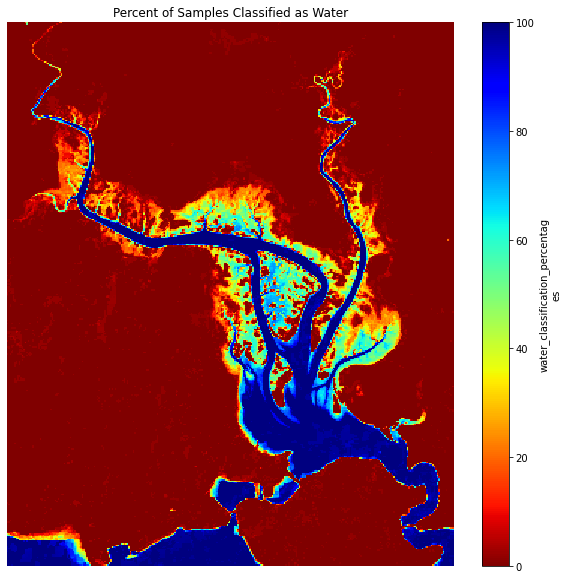

In [11]:
# This is where the WOFS time series product is generated. 
# Areas of RED have experienced little or no water over the time series
# Areas of BLUE have experience significant or constant water over the time series

water_classification_percentages.plot(cmap = jet_r, figsize=(10,10))
plt.title("Percent of Samples Classified as Water")
plt.axis('off')
plt.show()